In [121]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy.linalg as la
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [129]:
T=2
M=100
N=100

def simple_a(x):
    return np.array((x-1/3)*(x-2/3))

def pos_a(x):
    a_vec=simple_a(x)
    null_vec=np.zeros(len(x))
    arr=np.maximum(null_vec, a_vec)
    return arr

def neg_a(x):
    null_vec=np.zeros(len(x))
    a_vec=-simple_a(x)
    arr=np.maximum(null_vec, a_vec)
    return arr
        
def tridiag(lower, diag, upper):
    return np.diag(lower, -1) + np.diag(diag) + np.diag(upper, 1)    

def plot_solutionTest(U, angle=-30, title="Title"):
    x_len = len(U[:,])
    t_len = len(U[0])
    
    x=np.linspace(0, 1, x_len) 
    t=np.linspace(0, T, t_len)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5), subplot_kw={"projection": "3d"})
    tt, xx = np.meshgrid(t, x)
    ax.plot_surface(tt, xx, U, cmap=cm.coolwarm)
    ax.view_init(azim=angle)              # Rotate the figure
    ax.set_title(title)
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('u')
    fig.tight_layout()

[[0.55555556 0.         0.         ... 0.         0.         0.        ]
 [0.42464444 0.57535556 0.         ... 0.         0.         0.        ]
 [0.         0.40524444 0.59475556 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.59475556 0.         0.        ]
 [0.         0.         0.         ... 0.42464444 0.57535556 0.        ]
 [0.         0.         0.         ... 0.         0.44444444 0.55555556]]


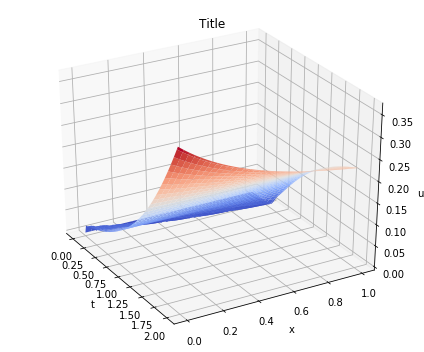

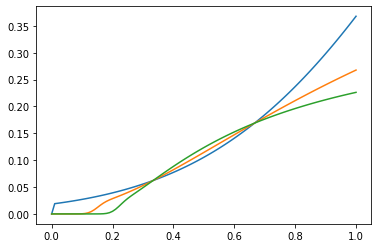

In [133]:
def init_test(x):
    return np.exp(-(x-2)*(x-2))

def bc_test(t):
    return t**2 

def upwind(M, T, N, u_init, u_bc):
    
    h=1/M
    k=T/N
    
    t=np.linspace(0, T, N+1)
    x=np.linspace(0, 1, M+1)
    
    U=np.zeros((N+1, M+1))
    
    U[0, :]=u_init(x)
    
    U[:, 0]=u_bc(t)
    
    lower=(k/h)*pos_a(x)[1:]
    middle=np.ones(len(x))-(k/h)*pos_a(x)[:]-(k/h)*neg_a(x)[:]
    upper=(k/h)*neg_a(x)[:-1]
    
    A=tridiag(lower, middle, upper)
    print(A)
    
    CFL=k/h*simple_a(x)
    
    for n in range(N):
        U[n+1, :]=A@U[n, :]
    
    return U, x, t, CFL

test, testx, testt, CFL=upwind(M, T, N, init_test, bc_test)

plot_solutionTest(test, angle=-30, title="Title")

#SER FEIL UT :P

plt.figure()
plt.plot(testx, test[0, :])
plt.plot(testx, test[50, :])
plt.plot(testx, test[100, :])
#plt.plot(testx, test[450, :])
#plt.plot(testx, test[700, :])
#plt.plot(testx, test[900, :])